<a target="_blank" href="https://colab.research.google.com/github/themis-ai/capsa/blob/main/notebooks/7_Composability.ipynb">
<img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# Composability (Advanced)

In this tutorial we showcase how our method can compose different algorithms together to quantify different risk metrics efficiently. We further show how the framework yields interpretable risk estimation results that can provide a deeper insight into decision boundaries of the NNs.

In [ ]:
!pip install capsa

# download helper functions for this tutorial
!git clone --depth 1 https://github.com/themis-ai/capsa.git
%cd /content/capsa/notebooks/utils/depth

# download and extract dataset
!wget -q http://argo-1.themisai.io/demos/nyu_depth/nyu.h5

In [2]:
import tensorflow as tf
import config as config

In [3]:
from utils import get_datasets
ds_train, ds_test = get_datasets(
    id_path = "nyu.h5"
)

By composibility we mean applying multiple wrappers sequentially. This combination results in a single risk aware model. Same as with any other ``Capsa`` wrapper, user could simply wrap their model with it. For example:
- ensembling any ``capsa`` wrapper: for instance, wrapping a ``base_model`` with one of the ``capsa``'s wrappers e.g. [VAEWrapper](https://themisai.io/capsa/api_documentation/VAEWrapper.html) and then applying [EnsembleWrapper](https://themisai.io/capsa/api_documentation/EnsembleWrapper.html) to the resulting model.
- wrapping a ``base_model`` with one of the ``capsa``'s wrappers e.g. [MVEWrapper](https://themisai.io/capsa/api_documentation/MVEWrapper.html) and then applying [DropoutWrapper](https://themisai.io/capsa/api_documentation/DropoutWrapper.html) to the resulting model.

There could be different reasons behind using composibility: the first approach outlined above helps to improve the uncertainty estimate of any of the ``Capsa`` wrappers (although at a significant computational cost); the second approach esentialy applies an epistemic wrapper to an aleatoric wrapper, potentially allowing to capture richer dependencies in the resulting risk estimate.

There potentially could be other ways of combining the wrappers with ``Capsa``.

Let's train our model. We'll demonstrate the first approach described above by ensembling dropout wrapper. We use the same "base model" as in the previous tutorials (part 5, part 6). 

In [4]:
from models import unet
from capsa import DropoutWrapper, EnsembleWrapper

base_model = unet(drop_prob=0.1)
# don't add dropout in the wrapper because our model already contains dropout layers
model = EnsembleWrapper(base_model, num_members=3, metric_wrapper=DropoutWrapper, kwargs={'p': 0.0})
model_name = "compatibility_dropout"

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.LR),
    loss="mse",
)

In [5]:
history = model.fit(
    ds_train,
    epochs=config.EP,
    validation_data=ds_test,
)

Epoch 1/20
256/256 [==============================] - 56s 192ms/step - dropout_0_compiled_loss: 0.1748 - dropout_0_wrapper_loss: 0.0821 - dropout_1_compiled_loss: 0.0831 - dropout_1_wrapper_loss: 0.0572 - dropout_2_compiled_loss: 0.1017 - dropout_2_wrapper_loss: 0.0647 - val_dropout_0_compiled_loss: 0.0810 - val_dropout_0_wrapper_loss: 0.0382 - val_dropout_1_compiled_loss: 0.0567 - val_dropout_1_wrapper_loss: 0.0382 - val_dropout_2_compiled_loss: 0.0643 - val_dropout_2_wrapper_loss: 0.0455
Epoch 2/20
256/256 [==============================] - 50s 194ms/step - dropout_0_compiled_loss: 0.0689 - dropout_0_wrapper_loss: 0.0389 - dropout_1_compiled_loss: 0.0515 - dropout_1_wrapper_loss: 0.0369 - dropout_2_compiled_loss: 0.0583 - dropout_2_wrapper_loss: 0.0422 - val_dropout_0_compiled_loss: 0.0598 - val_dropout_0_wrapper_loss: 0.0329 - val_dropout_1_compiled_loss: 0.0468 - val_dropout_1_wrapper_loss: 0.0318 - val_dropout_2_compiled_loss: 0.0532 - val_dropout_2_wrapper_loss: 0.0377
Epoch 3/20

Epoch 18/20
256/256 [==============================] - 50s 197ms/step - dropout_0_compiled_loss: 0.0123 - dropout_0_wrapper_loss: 0.0018 - dropout_1_compiled_loss: 0.0098 - dropout_1_wrapper_loss: 0.0016 - dropout_2_compiled_loss: 0.0121 - dropout_2_wrapper_loss: 0.0016 - val_dropout_0_compiled_loss: 0.0120 - val_dropout_0_wrapper_loss: 0.0019 - val_dropout_1_compiled_loss: 0.0096 - val_dropout_1_wrapper_loss: 0.0021 - val_dropout_2_compiled_loss: 0.0118 - val_dropout_2_wrapper_loss: 0.0023
Epoch 19/20
256/256 [==============================] - 50s 197ms/step - dropout_0_compiled_loss: 0.0118 - dropout_0_wrapper_loss: 0.0016 - dropout_1_compiled_loss: 0.0094 - dropout_1_wrapper_loss: 0.0014 - dropout_2_compiled_loss: 0.0116 - dropout_2_wrapper_loss: 0.0015 - val_dropout_0_compiled_loss: 0.0115 - val_dropout_0_wrapper_loss: 0.0014 - val_dropout_1_compiled_loss: 0.0091 - val_dropout_1_wrapper_loss: 0.0013 - val_dropout_2_compiled_loss: 0.0113 - val_dropout_2_wrapper_loss: 0.0014
Epoch 20

Perfect! We've traind our risk-aware model, now let's look at the loss curves.

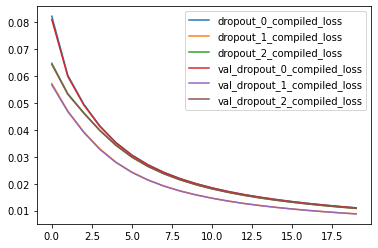

In [6]:
from utils import plot_loss
plot_loss(history, compiled_only=True)

Let's visualize model predictions. [DropoutWrapper](https://themisai.io/capsa/api_documentation/DropoutWrapper.html) is an epistemic wrapper and indeed we see that increased epistemic uncertainty roughly corresponds to the semantically and visually challenging pixels where the model is making errors.

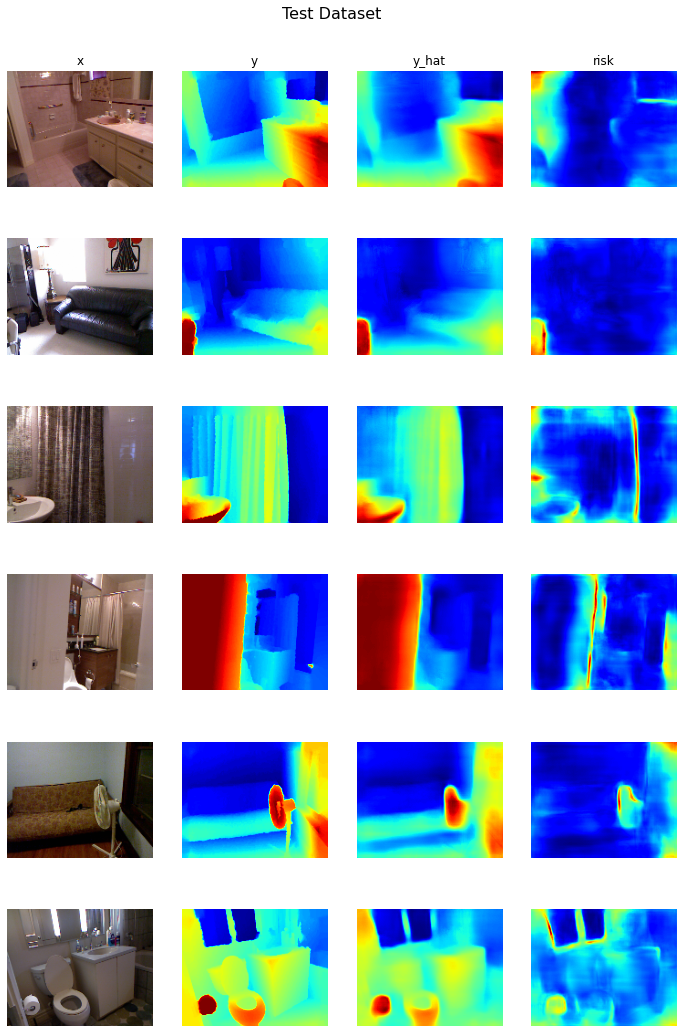

In [7]:
from utils import vis_depth_map
vis_depth_map(model, ds_test)

Let's look at the calibration plot that the model produces to quantitatively assess the quality of the risk estimate.

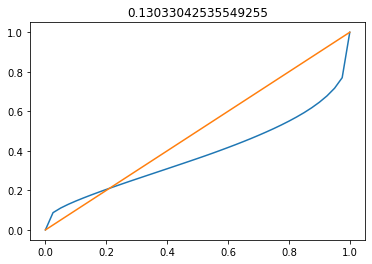

In [9]:
from capsa.utils import gen_calibration_plot
gen_calibration_plot(model, ds_test)

### To sum up 🏆
- We showcased how our method can compose different algorithms together to quantify different risk metrics.
- We further showed how the framework yields interpretable risk estimation results that can provide a deeper insight into decision boundaries of the NNs.